In [1]:
import abc
from collections.abc import Iterable  # pylint: disable=g-importing-member
import functools
from absl import logging
import gin
import jax
from jax import lax
from jax import random
import jax.numpy as jnp

import numpy as onp

In [15]:
shape = (2, 512, 16, 64)
onp.random.seed(10)
dtype = onp.float32
query = onp.random.rand(*shape).astype(dtype)  #(bs, len, num_heads, head_dim)
key = onp.random.rand(*shape).astype(dtype)
value = onp.random.rand(*shape).astype(dtype)
# loc = 0.0
# scale = 1.0
# dtype = onp.float32
# query = onp.random.normal(loc, scale, size=shape).astype(dtype)  #(bs, len, num_heads, head_dim)
# key = onp.random.normal(loc, scale, size=shape).astype(dtype)
# value = onp.random.normal(loc, scale, size=shape).astype(dtype)

print(query.dtype, query.shape)
query[0,0]


float32 (2, 512, 16, 64)


array([[0.77132064, 0.02075195, 0.6336482 , ..., 0.90283173, 0.53455794,
        0.5902014 ],
       [0.03928177, 0.35718176, 0.07961309, ..., 0.5982557 , 0.14762019,
        0.18403482],
       [0.6450721 , 0.04862801, 0.24861251, ..., 0.33867913, 0.09465904,
        0.71583086],
       ...,
       [0.9215931 , 0.15262388, 0.74999446, ..., 0.42338467, 0.7379784 ,
        0.9901201 ],
       [0.06883631, 0.85244584, 0.78474957, ..., 0.9454265 , 0.41213632,
        0.3258093 ],
       [0.3214651 , 0.2492156 , 0.7389259 , ..., 0.4773599 , 0.33000788,
        0.24054141]], dtype=float32)

In [3]:
# coding=utf-8
# Copyright 2020 The Google Research Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""Core Fast Attention Module for Flax.
Implementation of the approximate fast softmax and generalized
attention mechanism leveraging structured random feature maps [RFM] techniques
and low rank decomposition of the attention matrix.
"""
# pylint: disable=invalid-name, missing-function-docstring

import abc
from collections.abc import Iterable  # pylint: disable=g-importing-member
import functools
from absl import logging
import gin
import jax
from jax import lax
from jax import random
import jax.numpy as jnp

import numpy as onp

# Nonlinear mappings encoding different attention kernels.
gin.external_configurable(jnp.cos, 'jcos')
gin.external_configurable(jnp.sin, 'jsin')
gin.external_configurable(jnp.tanh, 'jtanh')
gin.external_configurable(jax.nn.sigmoid, 'jsigmoid')
gin.external_configurable(jax.nn.relu, 'jrelu')
gin.external_configurable(lambda x: x * x * (x > 0.0), 'jrequ')
gin.external_configurable(jax.nn.gelu, 'jgelu')
gin.external_configurable(jnp.exp, 'jexp')
gin.external_configurable(lambda x: x, 'jidentity')


def nonnegative_softmax_kernel_feature_creator(data,
                                               projection_matrix,
                                               attention_dims_t,
                                               batch_dims_t,
                                               precision,
                                               is_query,
                                               normalize_data=True,
                                               eps=0.0001):
  """Constructs nonnegative kernel features for fast softmax attention.
  Args:
    data: input for which features are computes
    projection_matrix: random matrix used to compute features
    attention_dims_t: tuple of attention dimensions
    batch_dims_t: tuple of batch dimensions
    precision: precision parameter
    is_query: predicate indicating whether input data corresponds to queries or
      keys
    normalize_data: predicate indicating whether data should be normalized,
    eps: numerical stabilizer.
  Returns:
    Random features for fast softmax attention.
  """
  del attention_dims_t
  if normalize_data:
    # We have e^{qk^T/sqrt{d}} = e^{q_norm k_norm^T}, where
    # w_norm = w * data_normalizer for w in {q,k}.
    data_normalizer = 1.0 / (jnp.sqrt(jnp.sqrt(data.shape[-1])))
  else:
    data_normalizer = 1.0
  ratio = 1.0 / jnp.sqrt(projection_matrix.shape[0])
  data_mod_shape = data.shape[0:len(batch_dims_t)] + projection_matrix.shape
  data_thick_random_matrix = jnp.zeros(data_mod_shape) + projection_matrix

  data_dash = lax.dot_general(
      data_normalizer * data,
      data_thick_random_matrix,
      (((data.ndim - 1,), (data_thick_random_matrix.ndim - 1,)),
       (batch_dims_t, batch_dims_t)),
      precision=precision)

  diag_data = jnp.square(data)
  diag_data = jnp.sum(diag_data, axis=data.ndim - 1)
  diag_data = (diag_data / 2.0) * data_normalizer * data_normalizer
  diag_data = jnp.expand_dims(diag_data, axis=data.ndim - 1)

  if is_query:
    last_dims_t = (len(data_dash.shape) - 1,)
    data_dash = ratio * (
        jnp.exp(data_dash - diag_data -
                jnp.max(data_dash, axis=last_dims_t, keepdims=True)) + eps)
  else:
    data_dash = ratio * (
        jnp.exp(data_dash - diag_data - jnp.max(data_dash)) + eps)

  return data_dash


def sincos_softmax_kernel_feature_creator(data,
                                          projection_matrix,
                                          attention_dims_t,
                                          batch_dims_t,
                                          precision,
                                          normalize_data=True):
  """Constructs kernel sin-cos features for fast softmax attention.
  Args:
    data: input for which features are computes
    projection_matrix: random matrix used to compute features
    attention_dims_t: tuple of attention dimensions
    batch_dims_t: tuple of batch dimensions
    precision: precision parameter
    normalize_data: predicate indicating whether data should be normalized.
  Returns:
    Random features for fast softmax attention.
  """
  if normalize_data:
    # We have: exp(qk^T/sqrt{d}) = exp(|q|^2/2sqrt{d}) * exp(|k|^2/2sqrt{d}) *
    # exp(-(|q*c-k*c|^2)/2), where c = 1.0 / sqrt{sqrt{d}}.
    data_normalizer = 1.0 / (jnp.sqrt(jnp.sqrt(data.shape[-1])))
  else:
    data_normalizer = 1.0
  ratio = 1.0 / jnp.sqrt(projection_matrix.shape[0])
  data_mod_shape = data.shape[0:len(batch_dims_t)] + projection_matrix.shape
  data_thick_random_matrix = jnp.zeros(data_mod_shape) + projection_matrix

  data_dash = lax.dot_general(
      data_normalizer * data,
      data_thick_random_matrix,
      (((data.ndim - 1,), (data_thick_random_matrix.ndim - 1,)),
       (batch_dims_t, batch_dims_t)),
      precision=precision)
  data_dash_cos = ratio * jnp.cos(data_dash)
  data_dash_sin = ratio * jnp.sin(data_dash)
  data_dash = jnp.concatenate((data_dash_cos, data_dash_sin), axis=-1)

  # Constructing D_data and data^{'}
  diag_data = jnp.square(data)
  diag_data = jnp.sum(diag_data, axis=data.ndim - 1)
  diag_data = (diag_data / 2.0) * data_normalizer * data_normalizer
  diag_data = jnp.expand_dims(diag_data, axis=data.ndim - 1)
  # Additional renormalization for numerical stability
  data_renormalizer = jnp.max(diag_data, attention_dims_t, keepdims=True)
  diag_data -= data_renormalizer
  diag_data = jnp.exp(diag_data)
  data_prime = data_dash * diag_data
  return data_prime


def generalized_kernel_feature_creator(data, projection_matrix, batch_dims_t,
                                       precision, kernel_fn, kernel_epsilon,
                                       normalize_data):
  """Constructs kernel features for fast generalized attention.
  Args:
    data: input for which features are computes
    projection_matrix: matrix used to compute features
    batch_dims_t: tuple of batch dimensions
    precision: precision parameter
    kernel_fn: kernel function used
    kernel_epsilon: additive positive term added to every feature for numerical
      stability
    normalize_data: predicate indicating whether data should be normalized.
  Returns:
    Random features for fast generalized attention.
  """
  if normalize_data:
    data_normalizer = 1.0 / (jnp.sqrt(jnp.sqrt(data.shape[-1])))
  else:
    data_normalizer = 1.0
  if projection_matrix is None:
    return kernel_fn(data_normalizer * data) + kernel_epsilon
  else:
    data_mod_shape = data.shape[0:len(batch_dims_t)] + projection_matrix.shape
    data_thick_random_matrix = jnp.zeros(data_mod_shape) + projection_matrix
    data_dash = lax.dot_general(
        data_normalizer * data,
        data_thick_random_matrix,
        (((data.ndim - 1,), (data_thick_random_matrix.ndim - 1,)),
         (batch_dims_t, batch_dims_t)),
        precision=precision)
  data_prime = kernel_fn(data_dash) + kernel_epsilon
  return data_prime


@gin.configurable
def make_fast_softmax_attention(qkv_dim,
                                renormalize_attention=True,
                                numerical_stabilizer=0.000001,
                                nb_features=256,
                                ortho_features=True,
                                ortho_scaling=0.0,
                                redraw_features=True,
                                unidirectional=False,
                                nonnegative_features=True,
                                lax_scan_unroll=1):
  """Construct a fast softmax attention method."""
  logging.info(
      'Fast softmax attention: %s features and orthogonal=%s, renormalize=%s',
      nb_features, ortho_features, renormalize_attention)
  if ortho_features:
    matrix_creator = functools.partial(
        GaussianOrthogonalRandomMatrix,
        nb_features,
        qkv_dim,
        scaling=ortho_scaling)
  else:
    matrix_creator = functools.partial(GaussianUnstructuredRandomMatrix,
                                       nb_features, qkv_dim)
  if nonnegative_features:

    def kernel_feature_creator(data,
                               projection_matrix,
                               attention_dims_t,
                               batch_dims_t,
                               precision,
                               is_query,
                               normalize_data=True):
      return nonnegative_softmax_kernel_feature_creator(
          data, projection_matrix, attention_dims_t, batch_dims_t, precision,
          is_query, normalize_data, numerical_stabilizer)
  else:

    def kernel_feature_creator(data,
                               projection_matrix,
                               attention_dims_t,
                               batch_dims_t,
                               precision,
                               is_query,
                               normalize_data=True):
      del is_query
      return sincos_softmax_kernel_feature_creator(data, projection_matrix,
                                                   attention_dims_t,
                                                   batch_dims_t, precision,
                                                   normalize_data)

  attention_fn = FastAttentionviaLowRankDecomposition(
      matrix_creator,
      kernel_feature_creator,
      renormalize_attention=renormalize_attention,
      numerical_stabilizer=numerical_stabilizer,
      redraw_features=redraw_features,
      unidirectional=unidirectional,
      lax_scan_unroll=lax_scan_unroll).dot_product_attention
  return attention_fn


@gin.configurable
def make_fast_generalized_attention(qkv_dim,
                                    renormalize_attention=True,
                                    numerical_stabilizer=0.0,
                                    nb_features=256,
                                    features_type='deterministic',
                                    kernel_fn=jax.nn.relu,
                                    kernel_epsilon=0.001,
                                    redraw_features=False,
                                    unidirectional=False,
                                    lax_scan_unroll=1):
  """Construct a fast generalized attention menthod."""
  logging.info('Fast generalized attention.: %s features and renormalize=%s',
               nb_features, renormalize_attention)
  if features_type == 'ortho':
    matrix_creator = functools.partial(
        GaussianOrthogonalRandomMatrix, nb_features, qkv_dim, scaling=False)
  elif features_type == 'iid':
    matrix_creator = functools.partial(GaussianUnstructuredRandomMatrix,
                                       nb_features, qkv_dim)
  elif features_type == 'deterministic':
    matrix_creator = None
  else:
    raise ValueError('Unknown feature value type')

  def kernel_feature_creator(data,
                             projection_matrix,
                             attention_dims_t,
                             batch_dims_t,
                             precision,
                             is_query,
                             normalize_data=False):
    del attention_dims_t
    del is_query
    return generalized_kernel_feature_creator(data, projection_matrix,
                                              batch_dims_t, precision,
                                              kernel_fn, kernel_epsilon,
                                              normalize_data)

  attention_fn = FastAttentionviaLowRankDecomposition(
      matrix_creator,
      kernel_feature_creator,
      renormalize_attention=renormalize_attention,
      numerical_stabilizer=numerical_stabilizer,
      redraw_features=redraw_features,
      unidirectional=unidirectional,
      lax_scan_unroll=lax_scan_unroll).dot_product_attention
  return attention_fn


class RandomMatrix(object):
  r"""Abstract class providing a method for constructing 2D random arrays.
  Class is responsible for constructing 2D random arrays.
  """

  __metaclass__ = abc.ABCMeta

  @abc.abstractmethod
  def get_2d_array(self):
    raise NotImplementedError('Abstract method')


class GaussianUnstructuredRandomMatrix(RandomMatrix):

  def __init__(self, nb_rows, nb_columns, key):
    self.nb_rows = nb_rows
    self.nb_columns = nb_columns
    self.key = key

  def get_2d_array(self):
    return random.normal(self.key, (self.nb_rows, self.nb_columns))


class GaussianOrthogonalRandomMatrix(RandomMatrix):
  r"""Class providing a method to create Gaussian orthogonal matrix.
  Class is responsible for constructing 2D Gaussian orthogonal arrays.
  """

  def __init__(self, nb_rows, nb_columns, key, scaling=0):
    self.nb_rows = nb_rows
    self.nb_columns = nb_columns
    self.key = key
    self.scaling = scaling

  def get_2d_array(self):
    nb_full_blocks = int(self.nb_rows / self.nb_columns)
    block_list = []
    rng = self.key
    for _ in range(nb_full_blocks):
      rng, rng_input = jax.random.split(rng)
      unstructured_block = random.normal(rng_input,
                                         (self.nb_columns, self.nb_columns))
#       unstructured_block = onp.random.normal(self.nb_columns, self.nb_columns)
      q, _ = jnp.linalg.qr(unstructured_block)
      q = jnp.transpose(q)
      block_list.append(q)
    remaining_rows = self.nb_rows - nb_full_blocks * self.nb_columns
    if remaining_rows > 0:
      rng, rng_input = jax.random.split(rng)
      unstructured_block = random.normal(rng_input,
                                         (self.nb_columns, self.nb_columns))
      q, _ = jnp.linalg.qr(unstructured_block)
      q = jnp.transpose(q)
      block_list.append(q[0:remaining_rows])
    final_matrix = jnp.vstack(block_list)

    if self.scaling == 0:
      multiplier = jnp.linalg.norm(
          random.normal(self.key, (self.nb_rows, self.nb_columns)), axis=1)
    elif self.scaling == 1:
      multiplier = jnp.sqrt(float(self.nb_columns)) * jnp.ones((self.nb_rows))
    else:
      raise ValueError('Scaling must be one of {0, 1}. Was %s' % self._scaling)

    return jnp.matmul(jnp.diag(multiplier), final_matrix)


class FastAttention(object):
  r"""Abstract class providing a method for fast attention.
  Class is responsible for providing a method <dot_product_attention> for fast
  approximate attention.
  """

  __metaclass__ = abc.ABCMeta

  @abc.abstractmethod
  def dot_product_attention(self,
                            query,
                            key,
                            value,
                            dtype=jnp.float32,
                            bias=None,
                            axis=None,
                            broadcast_dropout=True,
                            dropout_rng=None,
                            dropout_rate=0.,
                            deterministic=False,
                            precision=None):
    """Computes dot-product attention given query, key, and value.
    This is the core function for applying fast approximate dot-product
    attention. It calculates the attention weights given query and key and
    combines the values using the attention weights. This function supports
    multi-dimensional inputs.
    Args:
      query: queries for calculating attention with shape of [batch_size, dim1,
        dim2, ..., dimN, num_heads, mem_channels].
      key: keys for calculating attention with shape of [batch_size, dim1, dim2,
        ..., dimN, num_heads, mem_channels].
      value: values to be used in attention with shape of [batch_size, dim1,
        dim2,..., dimN, num_heads, value_channels].
      dtype: the dtype of the computation (default: float32)
      bias: bias for the attention weights. This can be used for incorporating
        autoregressive mask, padding mask, proximity bias.
      axis: axises over which the attention is applied.
      broadcast_dropout: bool: use a broadcasted dropout along batch dims.
      dropout_rng: JAX PRNGKey: to be used for dropout.
      dropout_rate: dropout rate.
      deterministic: bool, deterministic or not (to apply dropout).
      precision: numerical precision of the computation see `jax.lax.Precision`
        for details.
    Returns:
      Output of shape [bs, dim1, dim2, ..., dimN,, num_heads, value_channels].
    """
    raise NotImplementedError('Abstract method')


def _numerator_fwd(z_slice_shape, precision, qs, ks, vs):
  def body(p, qkv):
    (q, k, v) = qkv
    tmp= jnp.einsum('...m,...d->...md', k, v, precision=precision)
    p = p + tmp
    print("body p shape: ", p.shape) #(2, 16, 256, 64)
    print("body tmp shape: ", tmp.shape) #(2, 16, 256, 64)
    print("body q shape: ", q.shape) #(2, 16, 256)
    X_slice = jnp.einsum('...m,...md->...d', q, p, precision=precision)
    print("body X_slice shape: ", X_slice.shape) #(2, 16, 64)
    return p, X_slice
  init_value = jnp.zeros(z_slice_shape)
  print("body qs shape: ", qs.shape)
  p, W = lax.scan(body, init_value, (qs, ks, vs))
  return W, (p, qs, ks, vs)


def _numerator_bwd(z_slice_shape, precision, pqkv, W_ct):
  del z_slice_shape
  def body(carry, qkv_xct):
    p, p_ct = carry
    q, k, v, x_ct = qkv_xct
    q_ct = jnp.einsum('...d,...md->...m', x_ct, p, precision=precision)
    p_ct += jnp.einsum('...d,...m->...md', x_ct, q, precision=precision)
    k_ct = jnp.einsum('...md,...d->...m', p_ct, v, precision=precision)
    v_ct = jnp.einsum('...md,...m->...d', p_ct, k, precision=precision)
    p -= jnp.einsum('...m,...d->...md', k, v, precision=precision)
    return (p, p_ct), (q_ct, k_ct, v_ct)
  p, qs, ks, vs = pqkv
  _, (qs_ct, ks_ct, vs_ct) = lax.scan(
      body, (p, jnp.zeros_like(p)), (qs, ks, vs, W_ct), reverse=True)
  return qs_ct, ks_ct, vs_ct


@functools.partial(jax.custom_vjp, nondiff_argnums=(0, 1))
def _numerator(z_slice_shape, precision, qs, ks, vs):
  W, _ = _numerator_fwd(z_slice_shape, precision, qs, ks, vs)
  return W

_numerator.defvjp(_numerator_fwd, _numerator_bwd)

# (bs, num_heads, head_dim), (len, bs, num_heads, head_dim)
def _denominator_fwd(t_slice_shape, precision, qs, ks):
  def body(p, qk):
    q, k = qk
    p += k
    x = jnp.einsum('...m,...m->...', q, p, precision=precision)
    print(x.shape)
    return p, x

  p = jnp.zeros(t_slice_shape)
  p, R = lax.scan(body, p, (qs, ks))
  return R, (qs, ks, p)


def _denominator_bwd(_t_slice_shape, precision, qkp, R_ct):
  def body(carry, qkx):
    p, p_ct = carry
    q, k, x_ct = qkx
    q_ct = jnp.einsum('...,...m->...m', x_ct, p, precision=precision)
    p_ct += jnp.einsum('...,...m->...m', x_ct, q, precision=precision)
    k_ct = p_ct
    p -= k
    return (p, p_ct), (q_ct, k_ct)
  qs, ks, p = qkp
  _, (qs_ct, ks_ct) = lax.scan(body, (p, jnp.zeros_like(p)),
                               (qs, ks, R_ct), reverse=True)
  return (qs_ct, ks_ct)


@functools.partial(jax.custom_vjp, nondiff_argnums=(0, 1))
def _denominator(t_slice_shape, precision, qs, ks): # (bs, num_heads, head_dim), (len, bs, num_heads, head_dim)
  R, _ = _denominator_fwd(t_slice_shape, precision, qs, ks)
  return R

_denominator.defvjp(_denominator_fwd, _denominator_bwd)


class FastAttentionviaLowRankDecomposition(FastAttention):
  r"""Class providing a method for fast attention via low rank decomposition.
  Class is responsible for providing a method <dot_product_attention> for fast
  dot-product attention with the use of low rank decomposition (e.g. with
  random feature maps).
  """

  def __init__(self,
               matrix_creator,
               kernel_feature_creator,
               renormalize_attention,
               numerical_stabilizer,
               redraw_features,
               unidirectional,
               lax_scan_unroll=1):  # For optimal GPU performance, set to 16.
    rng = random.PRNGKey(0)
    self.matrix_creator = matrix_creator
    self.projection_matrix = self.draw_weights(rng)
    self.kernel_feature_creator = kernel_feature_creator
    self.renormalize_attention = renormalize_attention
    self.numerical_stabilizer = numerical_stabilizer
    self.redraw_features = redraw_features
    self.unidirectional = unidirectional
    self.lax_scan_unroll = lax_scan_unroll

  def draw_weights(self, key):
    if self.matrix_creator is None:
      return None
    matrixrng, _ = random.split(key)
    projection_matrix = self.matrix_creator(key=matrixrng).get_2d_array()
    return projection_matrix

  def dot_product_attention(self,
                            query,   # (bs, len, num_heads, head_dim)
                            key,     # (bs, len, num_heads, head_dim)
                            value,   # (bs, len, num_heads, head_dim)
                            dtype=jnp.float32,
                            bias=None,
                            axis=None,
                            broadcast_dropout=True,
                            dropout_rng=None,
                            dropout_rate=0.,
                            deterministic=False,
                            precision=None):

    assert key.shape[:-1] == value.shape[:-1]
    assert (query.shape[0:1] == key.shape[0:1] and
            query.shape[-1] == key.shape[-1])
    if axis is None:
      axis = tuple(range(1, key.ndim - 2))  # axis=(1,)
    if not isinstance(axis, Iterable):
      axis = (axis,)
    assert key.ndim == query.ndim
    assert key.ndim == value.ndim
    for ax in axis:
      if not (query.ndim >= 3 and 1 <= ax < query.ndim - 2):
        raise ValueError('Attention axis must be between the batch '
                         'axis and the last-two axes.')
    n = key.ndim
    res_value = []
    # Constructing projection tensor.
    if self.redraw_features:
      # TODO(kchoro): Get rid of the constant below.
      query_seed = lax.convert_element_type(
          jnp.ceil(jnp.sum(query) * 10000000.0), jnp.int32)
      rng = random.PRNGKey(query_seed)
      self.projection_matrix = self.draw_weights(rng)

    # batch_dims is  <bs, <non-attention dims>, num_heads>
    batch_dims = tuple(onp.delete(range(n), axis + (n - 1,)))  # (0, 2)
    # q & k -> (bs, <non-attention dims>, num_heads, <attention dims>, channels)  #(bs, num_heads, len, head_dim)
    qk_perm = batch_dims + axis + (n - 1,)       # (0, 2, 1, 3)
    k_extra_perm = axis + batch_dims + (n - 1,)  # (1, 0, 2, 3)
    key_extra = key.transpose(k_extra_perm)      # (bs, len, num_heads, head_dim) -> (len, bs, num_heads, head_dim)

    key = key.transpose(qk_perm)                 # (bs, len, num_heads, head_dim) -> (bs, num_heads, len, head_dim)
    query = query.transpose(qk_perm)             # (bs, len, num_heads, head_dim) -> (bs, num_heads, len, head_dim)
    # v -> (bs, <non-attention dims>, num_heads, <attention dims>, channels)
    v_perm = batch_dims + axis + (n - 1,)
    value = value.transpose(v_perm)
    batch_dims_t = tuple(range(len(batch_dims)))  # (0, 1)
    attention_dims_t = tuple(                     # (2,)
        range(len(batch_dims),
              len(batch_dims) + len(axis)))

    # Constructing tensors Q^{'} and K^{'}.
    query_prime = self.kernel_feature_creator(query, self.projection_matrix,
                                              attention_dims_t, batch_dims_t,
                                              precision, True)
    key_prime = self.kernel_feature_creator(key, self.projection_matrix,
                                            attention_dims_t, batch_dims_t,
                                            precision, False)
#     query_prime = query
#     key_prime = key
    res_value.append(query_prime)
    res_value.append(key_prime)
    if self.unidirectional:
      index = attention_dims_t[0]  # 2
      z_slice_shape = key_prime.shape[0:len(batch_dims_t)] + (
          key_prime.shape[-1],) + (value.shape[-1],)  # (bs, num_heads, feat_dim, head_dim)
      print("z_slice_shape: ", z_slice_shape)
      W = _numerator(z_slice_shape, precision,
                     jnp.moveaxis(query_prime, index, 0), # (bs, num_heads, len, feat_dim) -> (len, bs, num_heads, feat_dim)
                     jnp.moveaxis(key_prime, index, 0), # (bs, num_heads, len, feat_dim) -> (len, bs, num_heads, feat_dim)
                     jnp.moveaxis(value, index, 0)) # (bs, num_heads, len, head_dim) -> (len, bs, num_heads, head_dim)
      print("W shape: ", W.shape)
      # Constructing W = (Q^{'}(K^{'})^{T})_{masked}V
      W = jnp.moveaxis(W, 0, index)
      res_value.append(W)
      if not self.renormalize_attention:
        # Unidirectional, not-normalized attention.
        perm_inv = _invert_perm(qk_perm)
        result = W.transpose(perm_inv)
        return result, self.projection_matrix, res_value
      else:
        # Unidirectional, normalized attention.
        thick_all_ones = jnp.zeros(key.shape[0:-1]) + jnp.ones(  # (bs, num_heads, len) + (len)
            key_extra.shape[0:len(axis)])

        index = attention_dims_t[0] # 2
        t_slice_shape = key_prime.shape[0:len(batch_dims_t)] + (  # (bs, num_heads, head_dim)
            key_prime.shape[-1],)
        R = _denominator(t_slice_shape, precision,
                         jnp.moveaxis(query_prime, index, 0),
                         jnp.moveaxis(key_prime, index, 0))

        R = jnp.moveaxis(R, 0, index)
    else:
      # bidirectional

      contract_query = tuple(
          range(len(batch_dims) + len(axis),
                len(batch_dims) + len(axis) + 1))  # (3,)
      contract_z = tuple(range(len(batch_dims), len(batch_dims) + 1))  #(2,)
      # Constructing Z = (K^{'})^{T}V
      # Z (bs, <non-attention dims>, num_heads, channels_m, channels_v)
      value = value.astype(onp.float32)
      Z = lax.dot_general(
          key_prime,
          value,
          ((attention_dims_t, attention_dims_t), (batch_dims_t, batch_dims_t)),
          precision=precision)
      print(Z.shape) # (2, 16, 128, 64)
      # Constructing W = Q^{'}Z = Q^{'}(K^{'})^{T}V
      # q (bs, <non-attention dims>, num_heads, <attention dims>, channels_m)
      # Z (bs, <non-attention dims>, num_heads, channels_m, channels_v)
      # W (bs,  <non-attention dims>, num_heads, <attention dims>, channels_v)
      W = lax.dot_general(
          query_prime,
          Z, ((contract_query, contract_z), (batch_dims_t, batch_dims_t)),
          precision=precision)
      res_value.append(W)
      print(W.shape) # (2, 16, 512, 64)
      if not self.renormalize_attention:
        # Bidirectional, not-normalized attention.
        perm_inv = _invert_perm(qk_perm)
        result = W.transpose(perm_inv)
        return result
      else:
        # Bidirectional, normalized attention.
        
        # T_lin = key_prime.sum(axis=2)
        # print(onp.sum(onp.abs(T_lin- T)))
        thick_all_ones = jnp.zeros(key.shape[0:-1]) + jnp.ones(
            key_extra.shape[0:len(axis)])  # (bs, num_heads, len) + (len,)
        print(thick_all_ones.shape, jnp.zeros(key.shape[0:-1]).shape, jnp.ones(
            key_extra.shape[0:len(axis)]).shape)  # (2, 16, 512) (2, 16, 512) (512,)
        contract_key = tuple(
            range(len(batch_dims),
                  len(batch_dims) + len(axis)))
        print("contract_key: ", contract_key) # contract_key:  (2,)
        contract_thick_all_ones = tuple(
            range(thick_all_ones.ndim - len(axis), thick_all_ones.ndim)) 
        print("contract_thick_all_ones: ", contract_thick_all_ones) # (2,)
        # Construct T = (K^{'})^{T} 1_L
        # k (bs, <non-attention dims>, num_heads, <attention dims>, channels)
        T = lax.dot_general(
            key_prime,
            thick_all_ones, ((contract_key, contract_thick_all_ones),
                             (batch_dims_t, batch_dims_t)),     # batch_dims_t: (0, 1)
            precision=precision)  # (2, 16, 512, 128), (2, 16, 512)
        print("T shape: ", T.shape) # (2, 16, 128)
        print("key_prime shape:", key_prime.shape)
        

        # Construct partition function: R = Q^{'} T = Q^{'}(K^{'})^{T} 1_L
        # q_p (bs, <non-attention dims>, num_heads, <attention dims>, channs_m)
        # T   (bs, <non-attention dims>, num_heads, channels_m)
        R = lax.dot_general(
            query_prime,
            T, (((query_prime.ndim - 1,), (T.ndim - 1,)),
                (batch_dims_t, range(0,
                                     len(T.shape) - 1))),
            precision=precision)
        print("R shape: ", R.shape) # (2, 16, 512, 128) * (2, 16, 128) -> (2, 16, 512)
    
#     R_zero_mask = onp.zeros(R.shape, dtype=onp.float32)
#     R_numerical_stabilizer_mask = R_zero_mask + 2*self.numerical_stabilizer
#     R_add = onp.where(onp.abs(R)<=self.numerical_stabilizer, R_numerical_stabilizer_mask, R_zero_mask)
#     R_lin = R+R_add
    
    R = R + 2 * self.numerical_stabilizer * (
        jnp.abs(R) <= self.numerical_stabilizer)
#     print(onp.sum(onp.abs(R_lin-R)))
    R = jnp.reciprocal(R)
    R = jnp.expand_dims(R, len(R.shape))
    print("R shape: ", R.shape)
    # W (bs, <non-attention dims>, num_heads, <attention dims>, channels_v)
    # R (bs, <non-attention dims>, num_heads, <attention dims>, extra_channel)
    result = W * R
    # back to (bs, dim1, dim2, ..., dimN, num_heads, channels)
    perm_inv = _invert_perm(qk_perm)
    result = result.transpose(perm_inv)
    return result, self.projection_matrix, res_value


def _invert_perm(perm):
  perm_inv = [0] * len(perm)
  for i, j in enumerate(perm): # (0, 2, 1, 3) -> (0, 1, 2, 3)
    perm_inv[j] = i
  return tuple(perm_inv)

In [4]:
attn_fn = make_fast_softmax_attention(64, nb_features=128, renormalize_attention=True, unidirectional=True)

W1022 17:16:13.275980 140518241646336 xla_bridge.py:131] No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [16]:
res1, proj_mat, res_vlaue_orig = attn_fn(query, key, value)
res1[0,0]

z_slice_shape:  (2, 16, 128, 64)
body qs shape:  (512, 2, 16, 128)
body p shape:  (2, 16, 128, 64)
body tmp shape:  (2, 16, 128, 64)
body q shape:  (2, 16, 128)
body X_slice shape:  (2, 16, 64)
W shape:  (512, 2, 16, 64)
(2, 16)
R shape:  (2, 16, 512, 1)


DeviceArray([[0.89746666, 0.96294826, 0.32802016, ..., 0.80106604,
              0.6299767 , 0.5999515 ],
             [0.12154661, 0.33884388, 0.13348654, ..., 0.9184139 ,
              0.45374778, 0.4534209 ],
             [0.9131297 , 0.8715915 , 0.11985779, ..., 0.8921651 ,
              0.25968593, 0.42838234],
             ...,
             [0.56346226, 0.20953037, 0.20959033, ..., 0.3638113 ,
              0.9341765 , 0.8188767 ],
             [0.63863283, 0.58186543, 0.22813772, ..., 0.74381965,
              0.08203907, 0.7640973 ],
             [0.13210867, 0.03546585, 0.26622096, ..., 0.34538937,
              0.8901089 , 0.15624902]], dtype=float32)

In [7]:
res1, proj_mat, res_vlaue_orig = attn_fn(query, key, value)
res1.shape, res1.dtype, proj_mat.shape, proj_mat.dtype

z_slice_shape:  (2, 16, 256, 64)
body qs shape:  (512, 2, 16, 256)
body p shape:  (2, 16, 256, 64)
body X_slice shape:  (2, 16, 64)
W shape:  (512, 2, 16, 64)


ValueError: not enough values to unpack (expected 3, got 2)

In [6]:
def softmax(X, theta = 1.0, axis = None):
    """
    Compute the softmax of each element along an axis of X.

    Parameters
    ----------
    X: ND-Array. Probably should be floats.
    theta (optional): float parameter, used as a multiplier
        prior to exponentiation. Default = 1.0
    axis (optional): axis to compute values along. Default is the
        first non-singleton axis.

    Returns an array the same size as X. The result will sum to 1
    along the specified axis.
    """

    # make X at least 2d
    y = onp.atleast_2d(X)

    # find axis
    if axis is None:
        axis = next(j[0] for j in enumerate(y.shape) if j[1] > 1)

    # multiply y against the theta parameter,
    y = y * float(theta)

    # subtract the max for numerical stability
    y = y - onp.expand_dims(onp.max(y, axis = axis), axis)

    # exponentiate y
    y = onp.exp(y)

    # take the sum along the specified axis
    ax_sum = onp.expand_dims(onp.sum(y, axis = axis), axis)

    # finally: divide elementwise
    p = y / ax_sum

    # flatten if X was 1D
    if len(X.shape) == 1: p = p.flatten()

    return p

In [9]:
import math
def attn(q, k, v, bi=True):
    # (bs, len, num_heads, head_dim)
    size_per_head = q.shape[-1]
    q = q.transpose(0, 2, 1, 3) 
    k = k.transpose(0, 2, 1, 3)
    v = v.transpose(0, 2, 1, 3)
    attn_score = onp.matmul(q, k.transpose(0, 1, 3, 2))
    attn_score = attn_score * (1.0 / math.sqrt(float(size_per_head)))
    if not bi:
        low_triangular_mask = (onp.tril(onp.ones(attn_score.shape[-2:]), 0)-1)*10000.
        attn_score = attn_score + low_triangular_mask[None, None, ...]
        print(low_triangular_mask[:5,:5])
    attention_probs = softmax(attn_score, axis=-1)
    context_layer = onp.matmul(attention_probs, v)
    context_layer = context_layer.transpose(0, 2, 1, 3)
    return context_layer

In [17]:
# res1 = attn_fn(query, key, value)
res2 = attn(query, key, value, bi=False)

[[     0. -10000. -10000. -10000. -10000.]
 [     0.      0. -10000. -10000. -10000.]
 [     0.      0.      0. -10000. -10000.]
 [     0.      0.      0.      0. -10000.]
 [     0.      0.      0.      0.      0.]]


In [18]:
res1.shape, res2.shape, res2.dtype

((2, 512, 16, 64), (2, 512, 16, 64), dtype('float64'))

In [19]:
onp.sum(onp.abs(res1-res2))/onp.prod(res1.shape)

0.0071478113532066345

In [20]:
res1[0, 0, 1]

DeviceArray([0.12154661, 0.33884388, 0.13348654, 0.6301668 , 0.4129922 ,
             0.6149349 , 0.06389272, 0.9051133 , 0.40727347, 0.24895161,
             0.5860845 , 0.7668272 , 0.10097831, 0.05885285, 0.31033   ,
             0.06754939, 0.4960545 , 0.92063195, 0.17771266, 0.31046286,
             0.47939324, 0.33753374, 0.7691507 , 0.96271557, 0.9018393 ,
             0.93640816, 0.87224925, 0.3215516 , 0.500465  , 0.47145137,
             0.8533109 , 0.20703106, 0.7489623 , 0.7105472 , 0.8590447 ,
             0.12227874, 0.6935543 , 0.46177316, 0.43412873, 0.6277745 ,
             0.6962692 , 0.00691365, 0.9690841 , 0.02563363, 0.27615362,
             0.58965224, 0.76309645, 0.33964157, 0.35636517, 0.76667356,
             0.17620529, 0.5233161 , 0.89150023, 0.3121818 , 0.6303713 ,
             0.20013994, 0.37827945, 0.30610737, 0.5822753 , 0.12941118,
             0.9384126 , 0.9184139 , 0.45374778, 0.4534209 ],            dtype=float32)

In [21]:
res2[0, 0, 1]

array([0.12154663, 0.33884388, 0.13348652, 0.63016695, 0.41299236,
       0.6149348 , 0.06389271, 0.90511352, 0.40727341, 0.2489516 ,
       0.58608454, 0.76682717, 0.10097832, 0.05885284, 0.31033006,
       0.06754939, 0.49605447, 0.92063183, 0.17771268, 0.31046286,
       0.47939333, 0.33753371, 0.76915061, 0.96271545, 0.90183926,
       0.93640804, 0.87224948, 0.32155159, 0.50046504, 0.47145137,
       0.8533107 , 0.20703107, 0.74896246, 0.71054715, 0.85904461,
       0.12227876, 0.6935544 , 0.46177319, 0.43412879, 0.62777448,
       0.69626921, 0.00691366, 0.96908402, 0.02563363, 0.27615362,
       0.58965212, 0.76309633, 0.33964157, 0.35636523, 0.76667362,
       0.17620531, 0.52331597, 0.89150065, 0.31218186, 0.63037133,
       0.20013994, 0.37827951, 0.3061074 , 0.58227539, 0.12941115,
       0.93841273, 0.91841376, 0.45374793, 0.45342094])

1048576


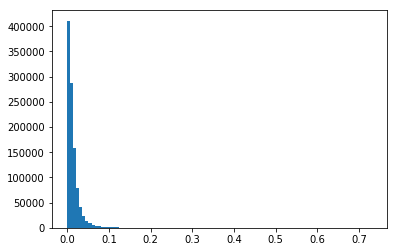

In [23]:
diff_ratio = onp.abs(res1-res2)/res2
import matplotlib.pyplot as plt
count = onp.prod(res1.shape)
print(count)
plt.hist(diff_ratio.reshape(-1), bins=100)
plt.show()

In [13]:
import matplotlib.pyplot as plt
diff = onp.abs(res1 - res2)
count = onp.prod(res1.shape)
print(count)
plt.hist(diff.reshape(-1), bins=100)
plt.show()

ValueError: operands could not be broadcast together with shapes (2,) (2,1024,16,64) 

In [12]:
for feat_dim in [32, 64, 128, 256, 512, 1024, 2048, 4096]:
    shape = (2, 1024, 16, 64)
    onp.random.seed(feat_dim+10)
    query = onp.random.rand(*shape) #(bs, len, num_heads, head_dim)
    key = onp.random.rand(*shape)
    value = onp.random.rand(*shape)
    attn_fn = make_fast_softmax_attention(64, nb_features=feat_dim, renormalize_attention=True)
    res1 = attn_fn(query, key, value)
    res2 = attn(query, key, value)
    mean_abs_diff = onp.sum(onp.abs(res1-res2))/onp.prod(res1.shape)
    print("feat_dim: %d, mean abs diff %.6f"%(feat_dim, mean_abs_diff))

(2, 16, 32, 64)
(2, 16, 1024, 64)
(2, 16, 1024) (2, 16, 1024) (1024,)
contract_key:  (2,)
contract_thick_all_ones:  (2,)
T shape:  (2, 16, 32)
key_prime shape: (2, 16, 1024, 32)
R shape:  (2, 16, 1024)
R shape:  (2, 16, 1024, 1)


ValueError: operands could not be broadcast together with shapes (2,) (2,1024,16,64) 

In [15]:
for feat_dim in [32, 64, 128, 256, 512, 1024, 2048, 4096]:
    shape = (2, 2048, 16, 64)
    onp.random.seed(feat_dim+10)
    query = onp.random.rand(*shape) #(bs, len, num_heads, head_dim)
    key = onp.random.rand(*shape)
    value = onp.random.rand(*shape)
    attn_fn = make_fast_softmax_attention(64, nb_features=feat_dim, renormalize_attention=True)
    res1 = attn_fn(query, key, value)
    res2 = attn(query, key, value)
    mean_abs_diff = onp.sum(onp.abs(res1-res2))/onp.prod(res1.shape)
    print("feat_dim: %d, mean abs diff %.6f"%(feat_dim, mean_abs_diff))

feat_dim: 32, mean abs diff 0.002560
feat_dim: 64, mean abs diff 0.002847
feat_dim: 128, mean abs diff 0.001985
feat_dim: 256, mean abs diff 0.001317
feat_dim: 512, mean abs diff 0.001854
feat_dim: 1024, mean abs diff 0.001208
feat_dim: 2048, mean abs diff 0.000938
feat_dim: 4096, mean abs diff 0.001445


In [16]:
def atten2(q, k, v):
    # (bs, len, num_heads, head_dim)
    size_per_head = q.shape[-1]
    n = q.shape[-2]
    q = q.transpose(0, 2, 1, 3) 
    k = k.transpose(0, 2, 1, 3)
    v = v.transpose(0, 2, 1, 3) # (bs, num_heads, len, head_dim)
    q_softmax = softmax(q, axis=-1) * 1.0/ math.sqrt(n)
    k_softmax = softmax(k, axis=-2) * 1.0/ math.sqrt(n)
    
    kv = onp.matmul(k_softmax.transpose(0, 1, 3, 2), v) # (bs, num_heads, head_dim, head_dim)
    context_layer = onp.matmul(q_softmax, kv) # (bs, num_heads, len, head_dim)
    context_layer = context_layer.transpose(0, 2, 1, 3)
    return context_layer

In [17]:
# res1 = attn_fn(query, key, value)
res2 = attn(query, key, value)
res3 = atten2(query, key, value)
onp.sum(onp.abs(res3-res2))/onp.prod(res1.shape)

0.468458336257408

In [18]:
res2[0, 0, 0]

array([0.49428869, 0.50142085, 0.49378735, 0.51016673, 0.50480644,
       0.50228521, 0.49877265, 0.48711779, 0.49409655, 0.49744293,
       0.48953286, 0.49621849, 0.49413408, 0.48669814, 0.49689139,
       0.50418089, 0.50991587, 0.49752703, 0.5046443 , 0.5069506 ,
       0.49321097, 0.51191124, 0.50095813, 0.49457211, 0.49548192,
       0.50744094, 0.49850628, 0.5037728 , 0.50300514, 0.50454333,
       0.50665546, 0.49696828, 0.49577153, 0.50219054, 0.49282323,
       0.49895454, 0.52016535, 0.50153318, 0.49412961, 0.49616413,
       0.49997897, 0.49429182, 0.48865578, 0.49620458, 0.49594426,
       0.50307947, 0.49252937, 0.4967054 , 0.49785785, 0.51761538,
       0.51158979, 0.51353982, 0.5145384 , 0.50457855, 0.49715276,
       0.4977709 , 0.48818036, 0.50533134, 0.49335693, 0.49985794,
       0.50688144, 0.48960757, 0.50037194, 0.48997852])

In [19]:
res3[0, 0, 0]

array([0.03091257, 0.03140684, 0.03083307, 0.03179559, 0.03149994,
       0.03141004, 0.0312512 , 0.03047129, 0.03089646, 0.03111978,
       0.03063871, 0.03101448, 0.03088606, 0.03034551, 0.03107876,
       0.03158305, 0.03187562, 0.03115086, 0.03154974, 0.03162817,
       0.03083868, 0.03199402, 0.03132343, 0.03095931, 0.03105424,
       0.03172261, 0.03126309, 0.03154043, 0.0314578 , 0.03154563,
       0.0317354 , 0.03117126, 0.03100561, 0.0313605 , 0.03074946,
       0.03115346, 0.03244557, 0.03139081, 0.03089449, 0.03102182,
       0.03122772, 0.03093461, 0.03049361, 0.03107778, 0.03104208,
       0.03147625, 0.03077831, 0.03106927, 0.03119094, 0.0322043 ,
       0.03200334, 0.03206791, 0.03214676, 0.03149196, 0.03098876,
       0.03103158, 0.03046521, 0.03157382, 0.03082395, 0.03120166,
       0.03171428, 0.03068032, 0.03127315, 0.0305605 ])

In [6]:
a = onp.ones((2,3,4,5))
b = onp.ones((2,3,5))
c = onp.einsum('...nd,...d->...n', a, b)
c.shape

(2, 3, 4)

In [24]:
import tensorflow as tf
import math
from functools import partial
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

def get_shape_list(tensor, expected_rank=None, name=None):
    """Returns a list of the shape of tensor, preferring static dimensions.
    Args:
      tensor: A tf.Tensor object to find the shape of.
      expected_rank: (optional) int. The expected rank of `tensor`. If this is
        specified and the `tensor` has a different rank, and exception will be
        thrown.
      name: Optional name of the tensor for the error message.
    Returns:
      A list of dimensions of the shape of tensor. All static dimensions will
      be returned as python integers, and dynamic dimensions will be returned
      as tf.Tensor scalars.
    """
    if name is None:
        name = tensor.name

    if expected_rank is not None:
        assert_rank(tensor, expected_rank, name)

    shape = tensor.shape.as_list()

    non_static_indexes = []
    for (index, dim) in enumerate(shape):
        if dim is None:
            non_static_indexes.append(index)

    if not non_static_indexes:
        return shape

    dyn_shape = tf.shape(tensor)
    for index in non_static_indexes:
        shape[index] = dyn_shape[index]
    return shape

def shape_list(x):
    """
    Deal with dynamic shape in tensorflow cleanly.

    Args:
        x (:obj:`tf.Tensor`): The tensor we want the shape of.

    Returns:
        :obj:`List[int]`: The shape of the tensor as a list.
    """
    static = x.shape.as_list()
    dynamic = tf.shape(x)
    return [dynamic[i] if s is None else s for i, s in enumerate(static)]


def nonnegative_softmax_kernel_feature_creator(data,
                                               projection_matrix,
                                               is_query,
                                               normalize_data=True,
                                               eps=0.000001):
    """Constructs nonnegative kernel features for fast softmax attention.
    Args:
    data: input for which features are computes
    projection_matrix: random matrix used to compute features
    attention_dims_t: tuple of attention dimensions
    batch_dims_t: tuple of batch dimensions
    precision: precision parameter
    is_query: predicate indicating whether input data corresponds to queries or
      keys
    normalize_data: predicate indicating whether data should be normalized,
    eps: numerical stabilizer.
    Returns:
    Random features for fast softmax attention.
    """
    if data.dtype != projection_matrix.dtype:
        projection_matrix = tf.saturate_cast(projection_matrix, data.dtype)

    if normalize_data:
        # We have e^{qk^T/sqrt{d}} = e^{q_norm k_norm^T}, where
        # w_norm = w * data_normalizer for w in {q,k}.
        data_shape = get_shape_list(data)
        data_normalizer = 1.0 / (math.sqrt(math.sqrt(float(data_shape[-1]))))
    else:
        data_normalizer = 1.0
    ratio = 1.0 / math.sqrt(float(get_shape_list(projection_matrix)[0]))
    # data_mod_shape = data.shape[:len(data.shape)-2] + projection_matrix.shape
    data_mod_shape = get_shape_list(data)[:len(data.shape)-2] + get_shape_list(projection_matrix)
    data_thick_random_matrix = tf.zeros(data_mod_shape, dtype=data.dtype) + projection_matrix  # broadcast to batch axis

    data_dash = tf.einsum('...id,...jd->...ij', (data_normalizer*data), data_thick_random_matrix)

    diag_data = data**2
    diag_data = tf.reduce_sum(diag_data, axis=-1)
    diag_data = (diag_data / 2.0) * data_normalizer**2
    diag_data = tf.expand_dims(diag_data, axis=-1)
    
    if is_query:
        data_dash = ratio * (
            tf.exp(data_dash - diag_data - tf.reduce_max(data_dash, axis=-1, keep_dims=True)) + eps)
    else:
        data_dash = ratio * (
            tf.exp(data_dash - diag_data - tf.reduce_max(data_dash)) + eps)
    
    return data_dash

@tf.custom_gradient
def my_eig(x):
    e, v = np.linalg.qr(x)
    def grad(grad_e, grad_v):
        return None
    return (e, v), grad

@tf.custom_gradient
def qr_wo_grad(x):
    q, r = tf.qr(x, full_matrices=False)
    q, r = tf.stop_gradient(q), tf.stop_gradient(r)
    def grad(dq, dr):
        return dq
    return (q, r), grad

def orthogonal_matrix_chunk(cols, dtype):
    use_numpy = False
    if use_numpy:
        unstructured_block = tf.random_normal((cols, cols), dtype=tf.float32)
        # with tf.GradientTape() as tape:
        #     tape.watch(unstructured_block)
        q, _ = tf.py_function(func=my_eig, inp=[unstructured_block], Tout=[tf.float32, tf.float32])
        q.set_shape(unstructured_block.get_shape())
        q = tf.saturate_cast(q, dtype=dtype)
        # print(q.shape)
    else:
        # unstructured_block = tf.stop_gradient(tf.random_normal((cols, cols), dtype=dtype))
        # q, r = tf.qr(unstructured_block, full_matrices=False)
        # q, r = tf.stop_gradient(q), tf.stop_gradient(r)
        # q, r = qr_wo_grad(unstructured_block)
        unstructured_block = tf.random_normal((cols, cols), dtype=tf.float32)
        q, r = tf.qr(unstructured_block, full_matrices=False)
    return tf.transpose(q)


def gaussian_orthogonal_random_matrix(nb_rows, nb_columns, scaling = 0, dtype=tf.float16):
    nb_full_blocks = int(nb_rows / nb_columns)

    block_list = []

    for _ in range(nb_full_blocks):
        q = orthogonal_matrix_chunk(nb_columns, dtype=dtype)
        block_list.append(q)

    remaining_rows = nb_rows - nb_full_blocks * nb_columns
    if remaining_rows > 0:
        q = orthogonal_matrix_chunk(nb_columns, dtype=dtype)
        block_list.append(q[:remaining_rows])

    final_matrix = tf.saturate_cast(tf.concat(block_list, 0), dtype=dtype)

    if scaling == 0:
        multiplier = tf.norm(tf.random_normal((nb_rows, nb_columns), dtype=dtype), axis=1)
    elif scaling == 1:
        multiplier = math.sqrt((float(nb_columns))) * tf.ones((nb_rows,), dtype=dtype)
    else:
        raise ValueError(f'Invalid scaling {scaling}')

    return tf.matmul(tf.diag(multiplier), final_matrix)


def np_orthogonal_matrix_chunk(cols):
    unstructured_block = np.random.normal(size=(cols, cols))
    q, _ = np.linalg.qr(unstructured_block)
    return q.T


def np_gaussian_orthogonal_random_matrix(nb_rows, nb_columns, scaling = 0, dtype=tf.float16):
    nb_full_blocks = int(nb_rows / nb_columns)

    block_list = []

    for _ in range(nb_full_blocks):
        q = np_orthogonal_matrix_chunk(nb_columns)
        block_list.append(q)

    remaining_rows = nb_rows - nb_full_blocks * nb_columns
    if remaining_rows > 0:
        q = np_orthogonal_matrix_chunk(nb_columns)
        block_list.append(q[:remaining_rows])

    final_matrix = np.concatenate(block_list, axis=0)
    final_matrix = tf.convert_to_tensor(final_matrix, dtype=dtype)
    if scaling == 0:
        multiplier = tf.norm(tf.random_normal((nb_rows, nb_columns), dtype=dtype), axis=1)
    elif scaling == 1:
        multiplier = math.sqrt((float(nb_columns))) * tf.ones((nb_rows,), dtype=dtype)
    else:
        raise ValueError(f'Invalid scaling {scaling}')

    return tf.matmul(tf.diag(multiplier), final_matrix)


# for bidirectional/masked language modelling
def linear_attention(q, k, v):
    context = tf.einsum('...nd,...ne->...de', k, v)
    out = tf.einsum('...de,...nd->...ne', context, q)
    return out

# # for unidirectional/causal modelling
# def causal_linear_attention(q, k, v):
#     k_cumsum = tf.cumsum(k, axis=-2)
#     context = tf.einsum('...nd,...ne->...nde', k, v)
#     context = tf.cumsum(context, axis=-3)
#     context /= tf.expand_dims(k_cumsum, axis=-1)
#     out = tf.einsum('...nde,...nd->...ne', context, q)
#     return out



# elems = np.array([1, 0, 0, 0, 0, 0])
# initializer = (np.array(0), np.array(1))
# fibonaccis = scan(lambda a, _: (a[1], a[0] + a[1]), elems, initializer)
# # fibonaccis == ([1, 1, 2, 3, 5, 8], [1, 2, 3, 5, 8, 13])
        
def causal_linear_attention(qs, ks, vs): #[bs, num_heads, len, head_dims]
    
    qs = tf.transpose(qs, (2, 0, 1, 3))
    ks = tf.transpose(ks, (2, 0, 1, 3))
    vs = tf.transpose(vs, (2, 0, 1, 3))
    z_slice_shape = (ks.shape[1], ks.shape[2], ks.shape[-1], vs.shape[-1])
    def body(p, qkv):
        (q, k, v) = qkv
        tmp= tf.einsum('...m,...d->...md', k, v)
        tmp_p = p[0] + tmp
        X_slice = tf.einsum('...m,...md->...d', q, tmp_p)
        return tmp_p, X_slice
    init_value = (tf.zeros(z_slice_shape, dtype=qs.dtype), tf.zeros(vs.shape[1:], dtype=qs.dtype))
    p, W = tf.scan(body, (qs, ks, vs), init_value) 
    return tf.transpose(W, (1,2,0,3))  # [bs, num_heads, len, head_dims]

def _denominator(qs, ks):
    # [bs, num_heads, len, head_dims] -> [len, bs, num_heads, head_dim]
    qs = tf.transpose(qs, (2, 0, 1, 3))
    ks = tf.transpose(ks, (2, 0, 1, 3))
    qs_shape = shape_list(qs)
    t_slice_shape = qs_shape[1:]    # (bs, num_heads, head_dim)
    res_shape = qs_shape[1:-1]
    def body(p, qk):
        q, k = qk
        tmp = p[0] + k
        x = tf.einsum('...m,...m->...', q, tmp)
        return tmp, x

    init_value = (tf.zeros(t_slice_shape, dtype=qs.dtype),
                  tf.zeros(res_shape, dtype=qs.dtype))
    p, R = tf.scan(body, (qs, ks), init_value) # R: (len, bs, num_heads)
    return tf.transpose(R, (1,2,0))

def fast_attention(q, k, v,
                   dim_heads,
                   nb_features=128,
                   redraw_projection=False,
                   ortho_scaling=0,
                   lm_type='bi',  # unibi, bi, plm
                   out_proj_mat=True,
                   renormalize_attention=True,
                   numerical_stabilizer=1e-6):
    q = tf.transpose(q, (0,2,1,3))
    k = tf.transpose(k, (0,2,1,3))
    v = tf.transpose(v, (0,2,1,3))
    q = tf.saturate_cast(q, tf.float32)
    k = tf.saturate_cast(k, tf.float32)
    v = tf.saturate_cast(v, tf.float32)
    res_value = []
    if redraw_projection:
        # random gaussian orthogonal random matrix for every training iteration
        projection_matrix = gaussian_orthogonal_random_matrix(nb_rows=nb_features,
                                                              nb_columns=dim_heads,
                                                              scaling=ortho_scaling,
                                                              dtype=q.dtype)
        # print("redraw")
    else:
#         # fixed gaussian orthogonal random matrix for every training iteration
#         projection_matrix = np_gaussian_orthogonal_random_matrix(nb_rows=nb_features,
#                                                                  nb_columns=dim_heads,
#                                                                  scaling=ortho_scaling,
#                                                                  dtype=q.dtype)
        # print("no-redraw")
        projection_matrix = tf.convert_to_tensor(onp.array(proj_mat), dtype=q.dtype)
    create_kernel = partial(nonnegative_softmax_kernel_feature_creator,
                            projection_matrix=projection_matrix, eps=numerical_stabilizer)
    q_prime = create_kernel(q, is_query=True) # [bs, num_heads, len, head_dims]
    k_prime = create_kernel(k, is_query=False)
#     q_prime = q
#     k_prime = k
    res_value.append(q_prime)
    res_value.append(k_prime)
    if lm_type == 'bi':
        out = linear_attention(q_prime, k_prime, v)
        res_value.append(out)
        if not renormalize_attention:
            out = tf.transpose(out, (0, 2, 1, 3))
            if out_proj_mat:
                return (out, projection_matrix), 
            else:
                return out
        else:
            # Construct T = (K^{'})^{T} 1_L
            T = tf.reduce_sum(k_prime, axis=2,
                              keep_dims=False)  # [bs, num_heads, len, head_dims] -> [bs, num_heads, head_dims]
            # Construct partition function: R = Q^{'} T = Q^{'}(K^{'})^{T} 1_L
            R = tf.einsum('...nd,...d->...n', q_prime, T)
    elif lm_type == 'unibi':
        out = causal_linear_attention(q_prime, k_prime, v)
        if not renormalize_attention:
            out = tf.transpose(out, (0, 2, 1, 3))
            res_value.append(out)
            if out_proj_mat:
                return (out, projection_matrix), res_value
            else:
                return out
        else:
            R = _denominator(q_prime, k_prime)

    elif lm_type == 'plm':
        NotImplementedError("Need to implement")
    R_shape = shape_list(R)
    R_zero_mask = tf.zeros(R_shape, dtype=R.dtype)
    R_numerical_stabilizer_mask = R_zero_mask + 2*numerical_stabilizer
    # R_add_numerical_stabilizer = tf.where(tf.abs(R) <= numerical_stabilizer, 2*numerical_stabilizer, 0.)
    R_add_numerical_stabilizer = tf.where(tf.abs(R) <= numerical_stabilizer, R_numerical_stabilizer_mask, R_zero_mask)
    R = R + R_add_numerical_stabilizer
    R = tf.expand_dims(tf.reciprocal(R), axis=-1) # [bs, num_heads, len] -> [bs, num_heads, len, 1]
    out = out * R
    # [bs, num_heads, len, head_dims]
    out = tf.transpose(out, (0, 2, 1, 3))
    if out_proj_mat:
        return (out, projection_matrix), res_value
    else:
        return out


In [25]:
tf.InteractiveSession()

In [26]:
q_tf = tf.constant(value=query)
k_tf = tf.constant(value=key)
v_tf = tf.constant(value=value)

In [27]:
# (res4, proj_mat_tf), res_value_tf = fast_attention(q_tf, k_tf, v_tf, 
#                                                    dim_heads=64, 
#                                                    nb_features=256, 
#                                                    renormalize_attention=False, 
#                                                    lm_type='unibi')
(res4, proj_mat_tf), res_value_tf = fast_attention(q_tf, k_tf, v_tf, 
                                                   dim_heads=64, 
                                                   nb_features=128, 
                                                   renormalize_attention=True, 
                                                   lm_type='unibi')

W1022 17:21:52.859043 140518241646336 deprecation.py:506] From <ipython-input-24-eea919aa8e2a>:100: calling reduce_max_v1 (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
W1022 17:21:53.058085 140518241646336 deprecation.py:323] From <ipython-input-24-eea919aa8e2a>:328: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [28]:
proj_mat_tf = proj_mat_tf.eval()

In [29]:
res4 = res4.eval()

In [30]:
res1.dtype, res4.dtype

(dtype('float32'), dtype('float32'))

In [31]:
onp.sum(onp.abs(res1-res4))/onp.prod(res1.shape)

1.1244449638070364e-07

In [32]:
res4[0,0, 0]

array([8.97466600e-01, 9.62948263e-01, 3.28020155e-01, 7.86812007e-01,
       1.13687376e-02, 7.32347190e-01, 4.09603089e-01, 2.03831524e-01,
       9.48454618e-01, 7.13827968e-01, 3.75037044e-01, 9.04710144e-02,
       3.70306194e-01, 8.71309459e-01, 8.32820907e-02, 1.18514225e-01,
       6.50837302e-01, 2.13438377e-01, 6.52033925e-01, 5.96800186e-02,
       1.95140187e-02, 6.87420309e-01, 3.46510410e-02, 1.03139736e-01,
       9.99977529e-01, 3.40717077e-01, 3.94634336e-01, 2.42169291e-01,
       9.89044845e-01, 7.46673346e-01, 9.13960099e-01, 7.44454682e-01,
       1.49573207e-01, 1.02939233e-01, 5.94359398e-01, 7.78720737e-01,
       8.78095746e-01, 9.02316332e-01, 8.75927925e-01, 4.81646687e-01,
       7.19547272e-02, 9.09988463e-01, 7.70958126e-01, 7.17091203e-01,
       6.88990712e-01, 4.43742603e-01, 4.21752967e-03, 6.18094742e-01,
       1.69340968e-01, 7.01120079e-01, 3.20408314e-01, 2.86291353e-04,
       8.27001095e-01, 5.56121111e-01, 3.66792798e-01, 8.09863091e-01,
      

In [33]:
res1[0,0, 0]

DeviceArray([8.97466660e-01, 9.62948263e-01, 3.28020155e-01,
             7.86811888e-01, 1.13687385e-02, 7.32347071e-01,
             4.09603208e-01, 2.03831583e-01, 9.48454559e-01,
             7.13828027e-01, 3.75037014e-01, 9.04710144e-02,
             3.70306134e-01, 8.71309638e-01, 8.32820833e-02,
             1.18514203e-01, 6.50837302e-01, 2.13438451e-01,
             6.52033806e-01, 5.96800074e-02, 1.95140168e-02,
             6.87420130e-01, 3.46510336e-02, 1.03139766e-01,
             9.99977529e-01, 3.40716928e-01, 3.94634247e-01,
             2.42169246e-01, 9.89044607e-01, 7.46673405e-01,
             9.13960218e-01, 7.44454384e-01, 1.49573132e-01,
             1.02939256e-01, 5.94359696e-01, 7.78720438e-01,
             8.78095865e-01, 9.02316213e-01, 8.75927627e-01,
             4.81646538e-01, 7.19547570e-02, 9.09988523e-01,
             7.70958126e-01, 7.17091262e-01, 6.88990593e-01,
             4.43742752e-01, 4.21752967e-03, 6.18094563e-01,
             1.69340938e

In [34]:
onp.sum(onp.abs(proj_mat-proj_mat_tf))/onp.prod(proj_mat.shape)

0.0

In [35]:
q_prime_tf, k_prime_tf, out_tf = [it.eval() for it in res_value_tf]
q_prime_o, k_prime_o, out_o = res_vlaue_orig

ValueError: not enough values to unpack (expected 3, got 2)

In [20]:
def diff2mat(a, b):
    return onp.sum(onp.abs(a-b))/onp.prod(a.shape)

In [21]:
diff2mat(q_prime_tf, q_prime_o)

7.401014523455984e-11

In [22]:
diff2mat(k_prime_tf, k_prime_o)

8.98882617644814e-12

In [24]:
diff2mat(out_tf.transpose(0,2,1,3), out_o)

0.10013184696435928

In [25]:
diff2mat(out_tf, out_o)

TypeError: sub got incompatible shapes for broadcasting: (2, 512, 16, 64), (2, 16, 512, 64).

In [4]:
#(2, 512, 16, 64)
q = query.transpose(0, 2, 1, 3) 
k = key.transpose(0, 2, 1, 3)
v = value.transpose(0, 2, 1, 3)
attn_score = onp.matmul(q, k.transpose(0, 1, 3, 2))
low_triangular_mask = onp.tril(onp.ones(attn_score.shape[-2:]), 0)
attn_score = attn_score * low_triangular_mask[None, None, ...]
print(attn_score[0,0, :5, :5])
context_layer = onp.matmul(attn_score, v)
print(context_layer.shape)
context_layer[0,0,0]

[[16.50806046  0.          0.          0.          0.        ]
 [16.29816246 17.48893929  0.          0.          0.        ]
 [15.91574478 16.28504562 16.20175552  0.          0.        ]
 [15.5081892  16.25076866 15.39020538 12.91930771  0.        ]
 [15.7975235  17.56301689 17.49247932 14.07947159 17.42897034]]
(2, 16, 512, 64)


array([1.48154339e+01, 1.58964101e+01, 5.41497754e+00, 1.29887412e+01,
       1.87675838e-01, 1.20896337e+01, 6.76175305e+00, 3.36486385e+00,
       1.56571481e+01, 1.17839172e+01, 6.19113518e+00, 1.49350097e+00,
       6.11303654e+00, 1.43836302e+01, 1.37482603e+00, 1.95643999e+00,
       1.07440615e+01, 3.52345412e+00, 1.07638145e+01, 9.85201355e-01,
       3.22138631e-01, 1.13479770e+01, 5.72021480e-01, 1.70263712e+00,
       1.65076895e+01, 5.62457860e+00, 6.51464797e+00, 3.99774529e+00,
       1.63272141e+01, 1.23261317e+01, 1.50877096e+01, 1.22895039e+01,
       2.46916379e+00, 1.69932733e+00, 9.81172284e+00, 1.28551700e+01,
       1.44956596e+01, 1.48954926e+01, 1.44598721e+01, 7.95105262e+00,
       1.18783323e+00, 1.50221455e+01, 1.27270253e+01, 1.18377859e+01,
       1.13739013e+01, 7.32533119e+00, 6.96232348e-02, 1.02035464e+01,
       2.79549119e+00, 1.15741336e+01, 5.28932032e+00, 4.72611545e-03,
       1.36521870e+01, 9.18048190e+00, 6.05503818e+00, 1.33692698e+01,
      

In [15]:
context_layer[0,0,-1]

array([4042.66284755, 3990.22515727, 3974.57602455, 3950.01565792,
       4034.0444153 , 3949.22006486, 4063.28383501, 4086.79502522,
       4060.83035086, 4231.00437254, 3835.17604203, 4057.66794557,
       4014.59497161, 3989.75054187, 3957.32204225, 4092.65127314,
       3965.08366841, 3985.22160199, 3889.88242935, 3928.79081328,
       4015.04298703, 3921.49873215, 3770.73859598, 4088.15464409,
       3950.66828529, 3935.88696788, 4078.42867247, 3910.79636011,
       3760.36368068, 3900.10490351, 3719.35855678, 3869.55099071,
       4058.49856933, 4194.3131201 , 3959.01618253, 3715.26492307,
       3927.54794701, 4039.79429695, 3975.83636138, 3828.5063419 ,
       4011.38153009, 4035.81040517, 4033.60301051, 3925.67112959,
       3922.30926799, 3970.74214615, 3900.81017108, 3903.0843065 ,
       3834.8749698 , 3901.90958478, 4017.29870386, 3961.33044824,
       3949.53327435, 4073.40464346, 3864.3495142 , 3995.36130589,
       4026.97116444, 3858.34154333, 4085.55536482, 3887.37478

In [20]:
res[0,0,0]

array([1.48154356e+01, 1.58964120e+01, 5.41497821e+00, 1.29887427e+01,
       1.87675860e-01, 1.20896351e+01, 6.76175387e+00, 3.36486427e+00,
       1.56571500e+01, 1.17839186e+01, 6.19113590e+00, 1.49350115e+00,
       6.11303727e+00, 1.43836318e+01, 1.37482621e+00, 1.95644022e+00,
       1.07440628e+01, 3.52345451e+00, 1.07638158e+01, 9.85201469e-01,
       3.22138669e-01, 1.13479784e+01, 5.72021547e-01, 1.70263732e+00,
       1.65076915e+01, 5.62457929e+00, 6.51464874e+00, 3.99774576e+00,
       1.63272161e+01, 1.23261332e+01, 1.50877113e+01, 1.22895053e+01,
       2.46916407e+00, 1.69932753e+00, 9.81172403e+00, 1.28551714e+01,
       1.44956614e+01, 1.48954943e+01, 1.44598738e+01, 7.95105355e+00,
       1.18783337e+00, 1.50221472e+01, 1.27270268e+01, 1.18377873e+01,
       1.13739027e+01, 7.32533205e+00, 6.96232432e-02, 1.02035476e+01,
       2.79549152e+00, 1.15741350e+01, 5.28932092e+00, 4.72611600e-03,
       1.36521886e+01, 9.18048300e+00, 6.05503895e+00, 1.33692715e+01,
      

In [23]:
res2[0,0,0]

array([1.48154364e+01, 1.58964128e+01, 5.41497850e+00, 1.29887409e+01,
       1.87675878e-01, 1.20896330e+01, 6.76175356e+00, 3.36486411e+00,
       1.56571512e+01, 1.17839212e+01, 6.19113684e+00, 1.49350107e+00,
       6.11303616e+00, 1.43836317e+01, 1.37482619e+00, 1.95643985e+00,
       1.07440615e+01, 3.52345443e+00, 1.07638149e+01, 9.85201359e-01,
       3.22138667e-01, 1.13479776e+01, 5.72021544e-01, 1.70263779e+00,
       1.65076923e+01, 5.62457895e+00, 6.51464748e+00, 3.99774575e+00,
       1.63272152e+01, 1.23261328e+01, 1.50877132e+01, 1.22895060e+01,
       2.46916413e+00, 1.69932783e+00, 9.81172276e+00, 1.28551741e+01,
       1.44956608e+01, 1.48954926e+01, 1.44598742e+01, 7.95105410e+00,
       1.18783343e+00, 1.50221472e+01, 1.27270260e+01, 1.18377876e+01,
       1.13739014e+01, 7.32533264e+00, 6.96232542e-02, 1.02035475e+01,
       2.79549217e+00, 1.15741358e+01, 5.28932047e+00, 4.72611655e-03,
       1.36521912e+01, 9.18048382e+00, 6.05503845e+00, 1.33692703e+01,
      

In [8]:
res=[]
q = query.transpose(1, 0, 2, 3)
k = key.transpose(1, 0, 2, 3)
v = value.transpose(1, 0, 2, 3)
p = onp.zeros((2, 16, 64, 64))
for i in range(q.shape[0]):
    tmp = onp.einsum('...m,...d->...md', k[i], v[i])
    p = p + tmp
    out = onp.einsum('...m,...md->...d', q[i], p)
    res.append(out[None,...])
res = onp.concatenate(res, 0).transpose(1,2,0,3)
res.shape

(2, 16, 512, 64)

In [ ]:
def _numerator_fwd(z_slice_shape, precision, qs, ks, vs):
  def body(p, qkv):
    (q, k, v) = qkv
    tmp= jnp.einsum('...m,...d->...md', k, v, precision=precision)
    p = p + tmp
    print("body p shape: ", p.shape) #(2, 16, 256, 64)
    print("body tmp shape: ", tmp.shape) #(2, 16, 256, 64)
    print("body q shape: ", q.shape) #(2, 16, 256)
    X_slice = jnp.einsum('...m,...md->...d', q, p, precision=precision)
    print("body X_slice shape: ", X_slice.shape) #(2, 16, 64)
    return p, X_slice
  init_value = jnp.zeros(z_slice_shape)
  print("body qs shape: ", qs.shape)
  p, W = lax.scan(body, init_value, (qs, ks, vs))
  return W, (p, qs, ks, vs)

In [21]:
#(2, 512, 16, 64)
q = query.transpose(0, 2, 1, 3) 
k = key.transpose(0, 2, 1, 3)
v = value.transpose(0, 2, 1, 3)
def causal_linear_attention(q, k, v): # (bs, num_head, len, head_dim)
#     k_cumsum = onp.cumsum(k, axis=-2)
    context = onp.einsum('...nd,...ne->...nde', k, v)
    context = onp.cumsum(context, axis=-3)
#     context /= onp.expand_dims(k_cumsum, axis=-1)
    out = onp.einsum('...nd,...nde->...ne', q, context)
    return out
res2 = causal_linear_attention(q,k,v)

In [22]:
res2.shape

(2, 16, 512, 64)